## The data grabbed from QFH antenna

The Parallella (Pcko) grabbing unit was used to capture triggered data from QFH antenna. Trigger was generated by oscilloscope from magnetic loop antenna. Tthe setup of trigger requeires minimal pulse width to generate the trigger signal. The trigger level was around 150mV and minimal pulse width ~ 105ns. 

The car with antenna mounted on the roof were parked in front of ODZ building. 


In [1]:
import os
from readrec import *

sps = 10e6 # 10 Msps
path = "/home/kaklik/data_hroch/cosmic/Experiments/2019/07_29_blesky"

for fn in os.listdir(path)[:1]:
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            h, samples, synclog = loadrec(f, skipsamples=True)
        except Exception as e:
            print(fn, e)
            continue


In [2]:
%matplotlib inline
import scipy.signal
import numpy as np
from pylab import plt
import math

def waterfallize_pre(signal, bins):
    window = 0.5 * (1.0 - np.cos((2 * math.pi * np.arange(bins)) / bins))
    segment = int(bins / 2)
    nsegments = int(len(signal) / segment)
    m = np.repeat(np.reshape(signal[0:segment * nsegments], (nsegments, segment)), 2, axis=0)
    t = np.reshape(m[1:len(m) - 1], (nsegments - 1, bins))
    img = np.multiply(t, window)
    wf = np.fft.fft(img)
    return np.concatenate((wf[:, int(bins / 2):bins], wf[:, 0:int(bins / 2)]), axis=1)

def waterfallize(signal, bins):
    return np.log(np.abs(waterfallize_pre(signal, bins)))

def abs2(x):
    return x.real**2 + x.imag**2

def wf(samples, sample_rate, freq_offset=0, freq_lim=None, bins=8192, ax=None, title=None):
    img = waterfallize(samples, bins).T
    img[np.isneginf(img)] = np.nan
    # ^^ might not be needed, was copied from pysdr-recviewer
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(24, 8))
    if title is not None:
        fig.suptitle(title)

    ax.imshow(img, extent=[0, len(samples)/sample_rate, freq_offset + sample_rate/2, freq_offset - sample_rate/2],
             aspect='auto', interpolation='none', cmap='magma')
    ax.set_xlabel('Time [s]'); ax.set_ylabel('Frequency [Hz]');
    
    if freq_lim is not None:
        ax.set_ylim(freq_lim[0] + freq_offset, freq_lim[1] + freq_offset)

    return ax


## Plotting of the data

Channels 2 and 3 were connected to GPS PPS and trigger pulses. 
Channels 4 and 5 were connected to the QFH antenna.


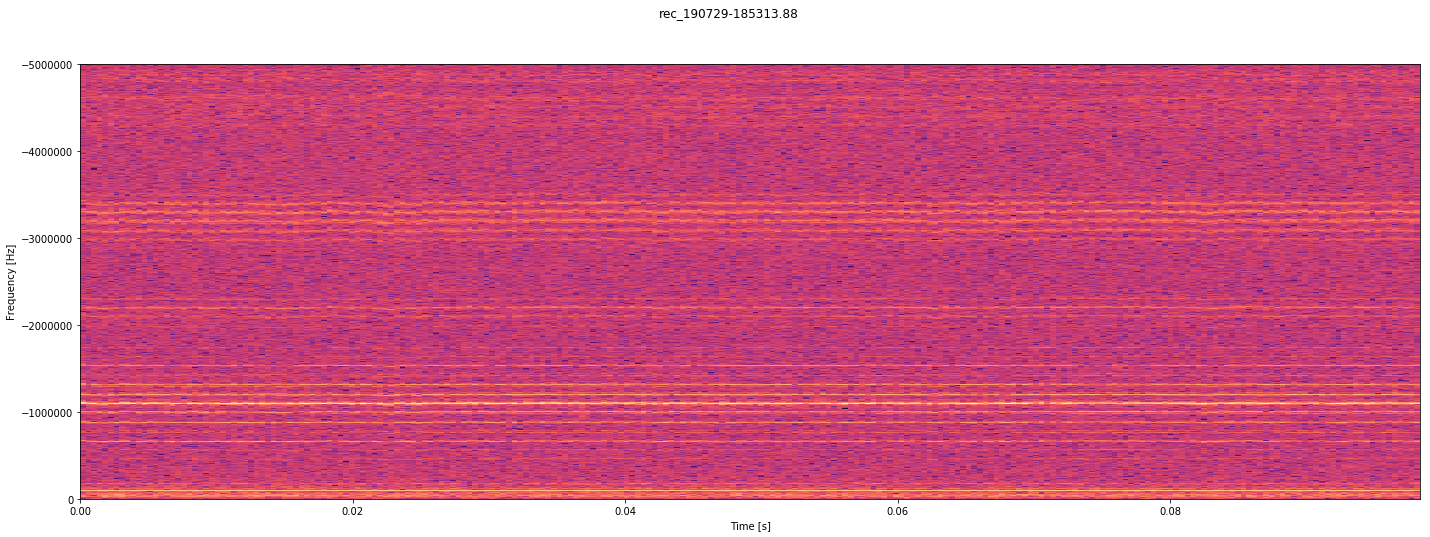

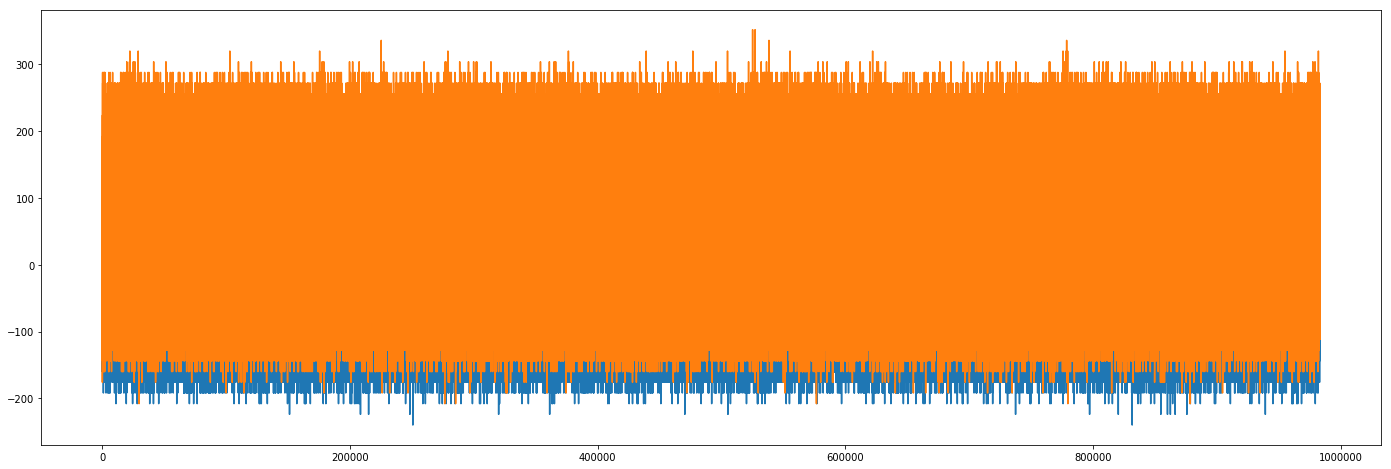

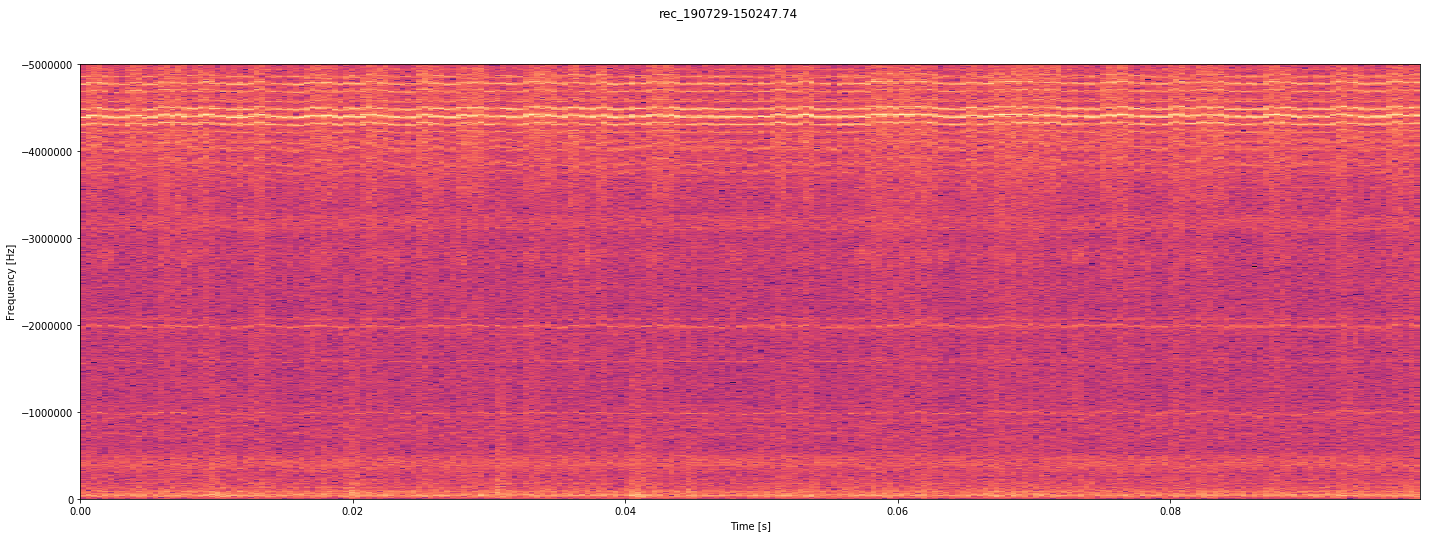

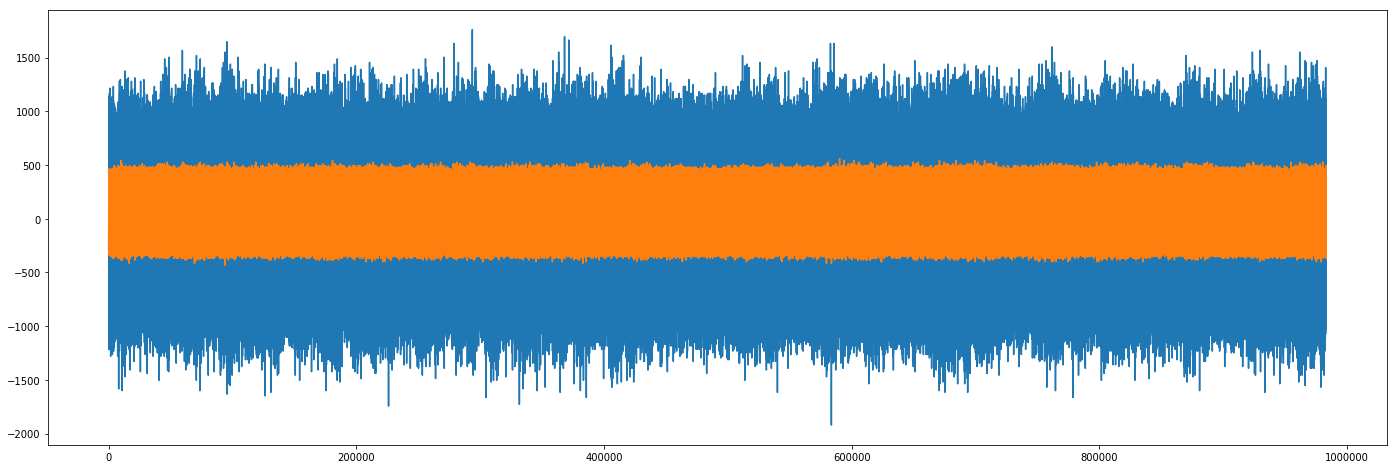

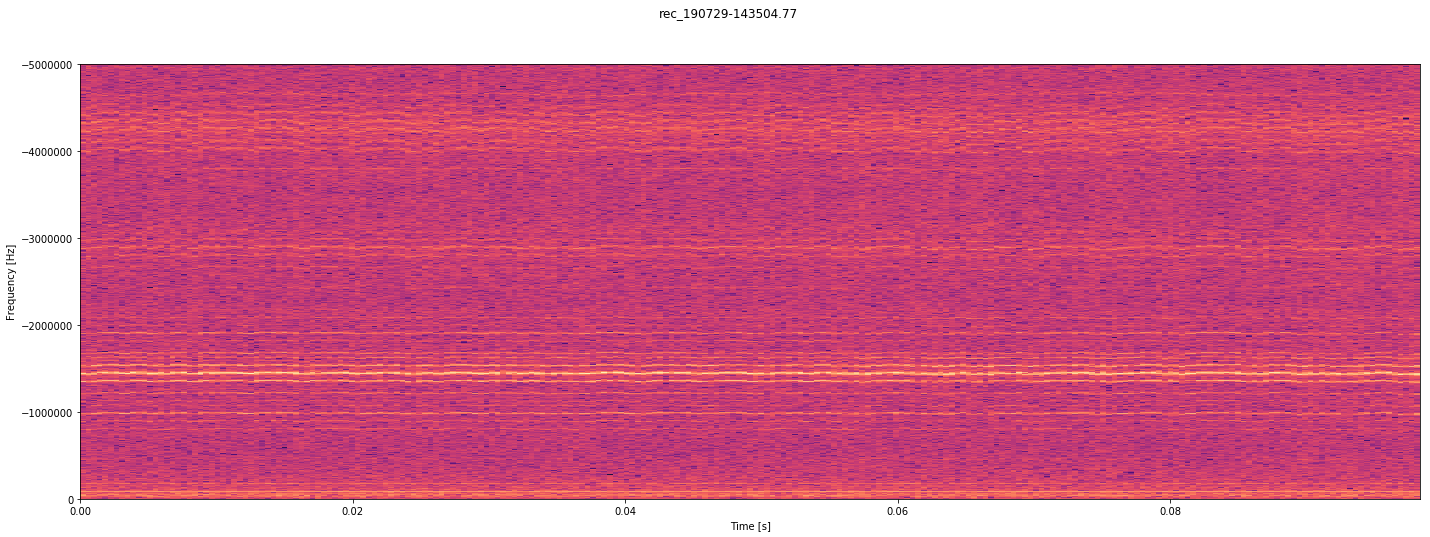

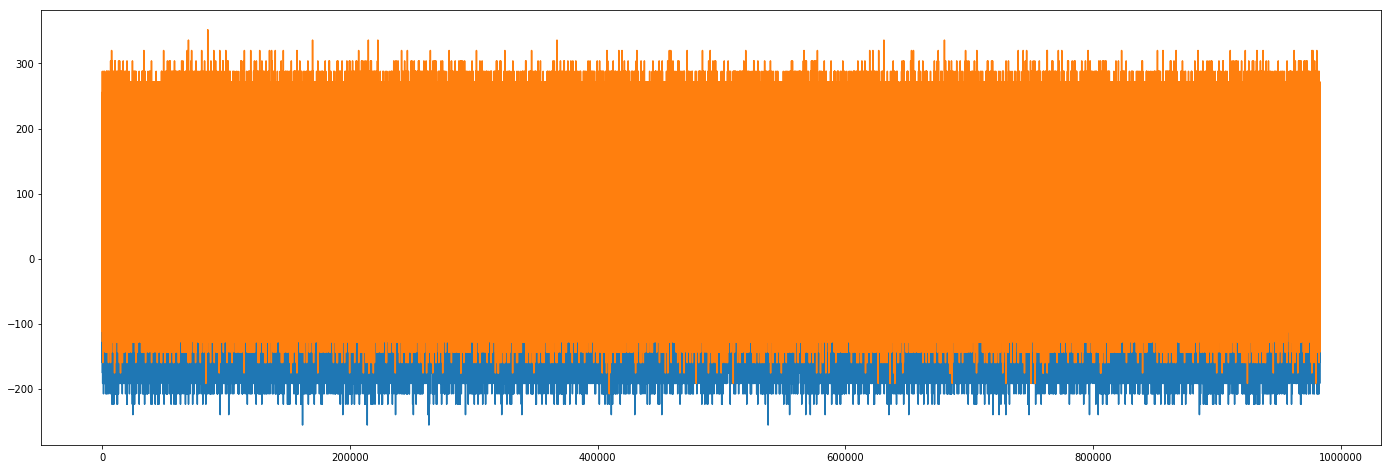

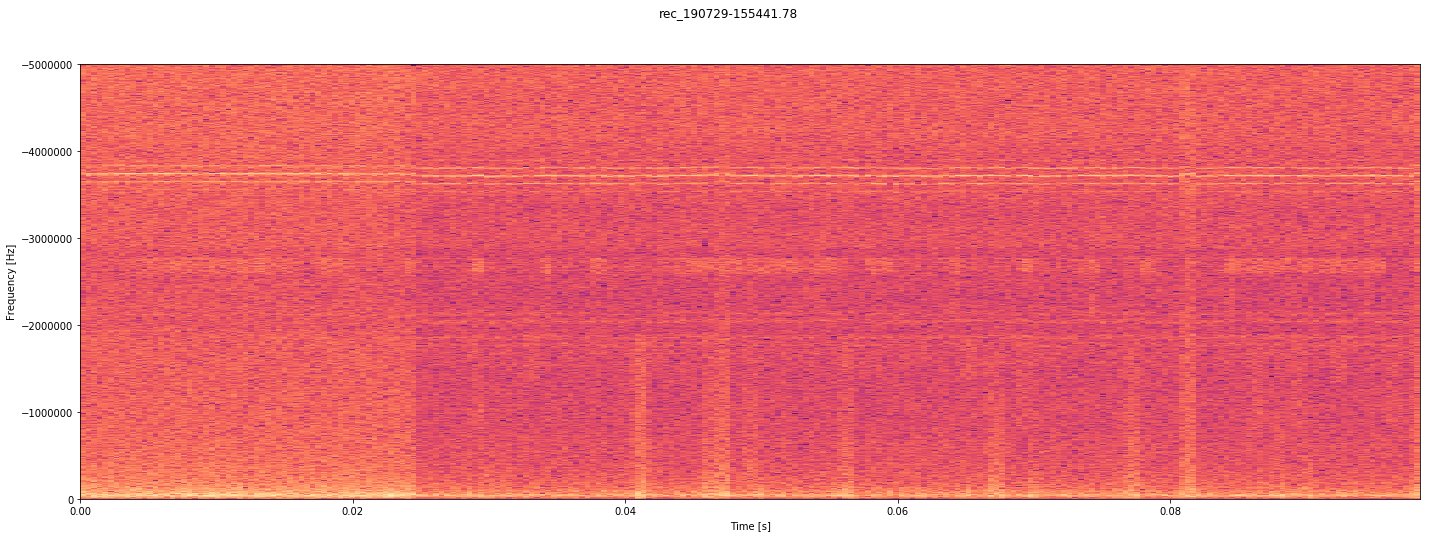

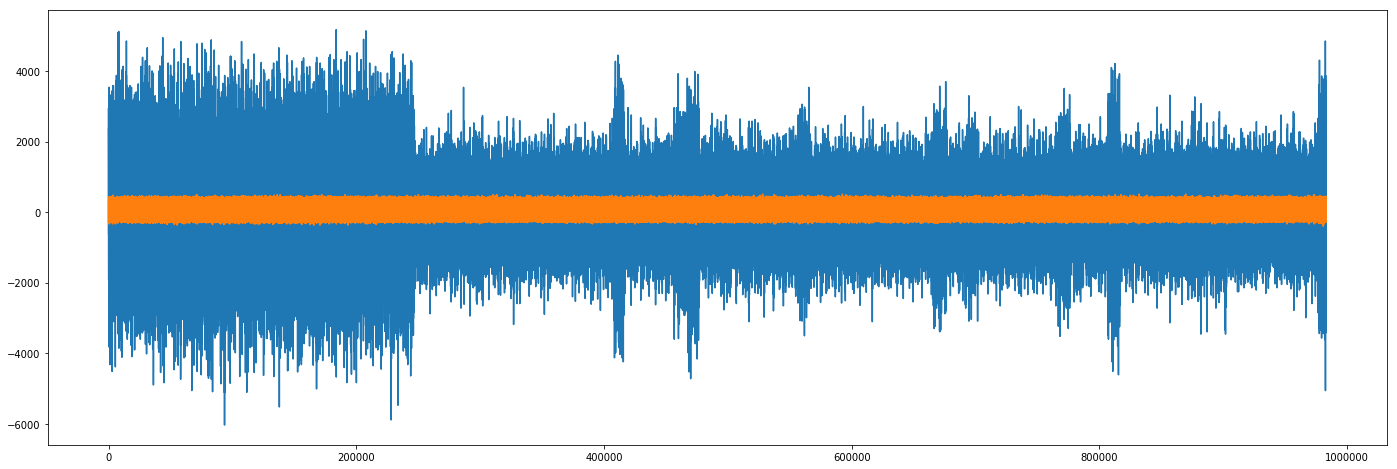

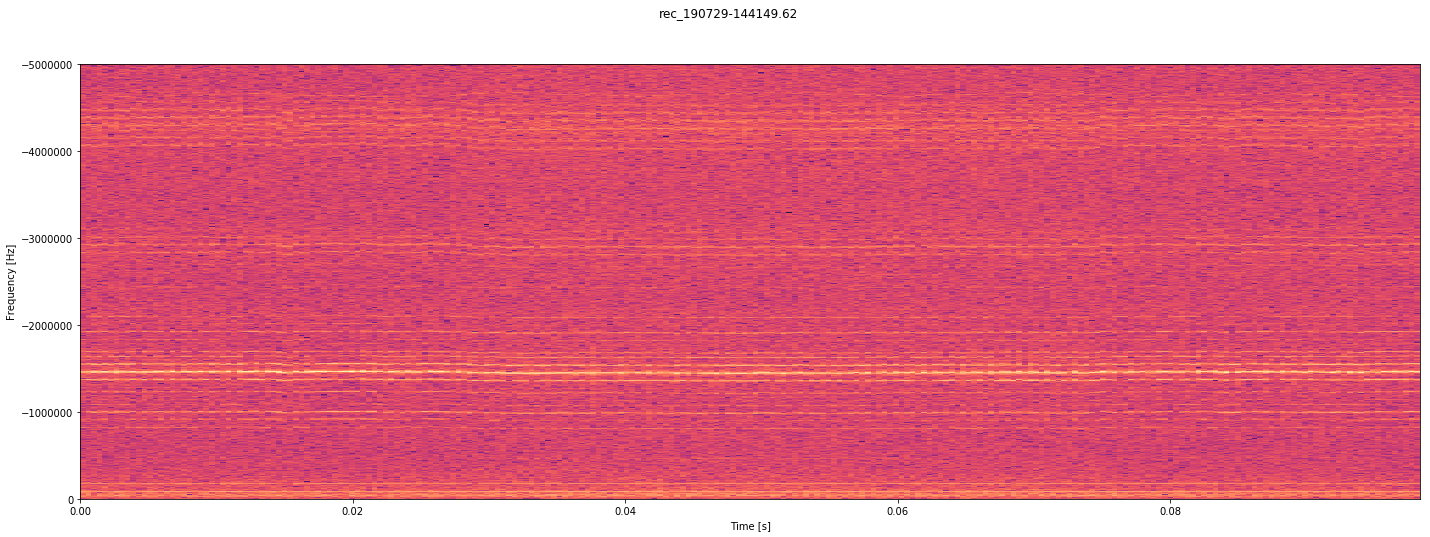

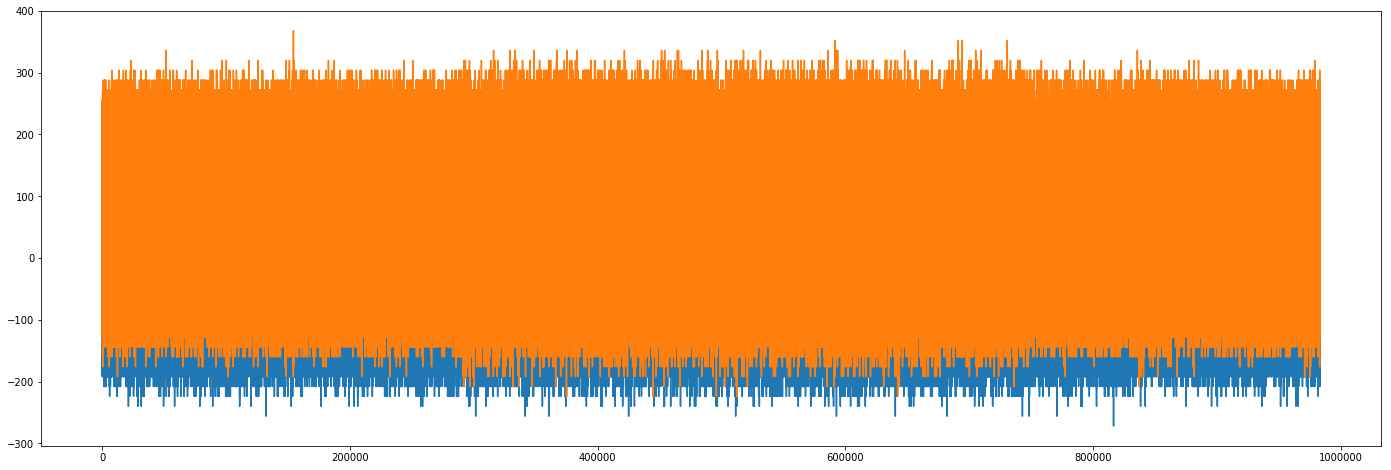

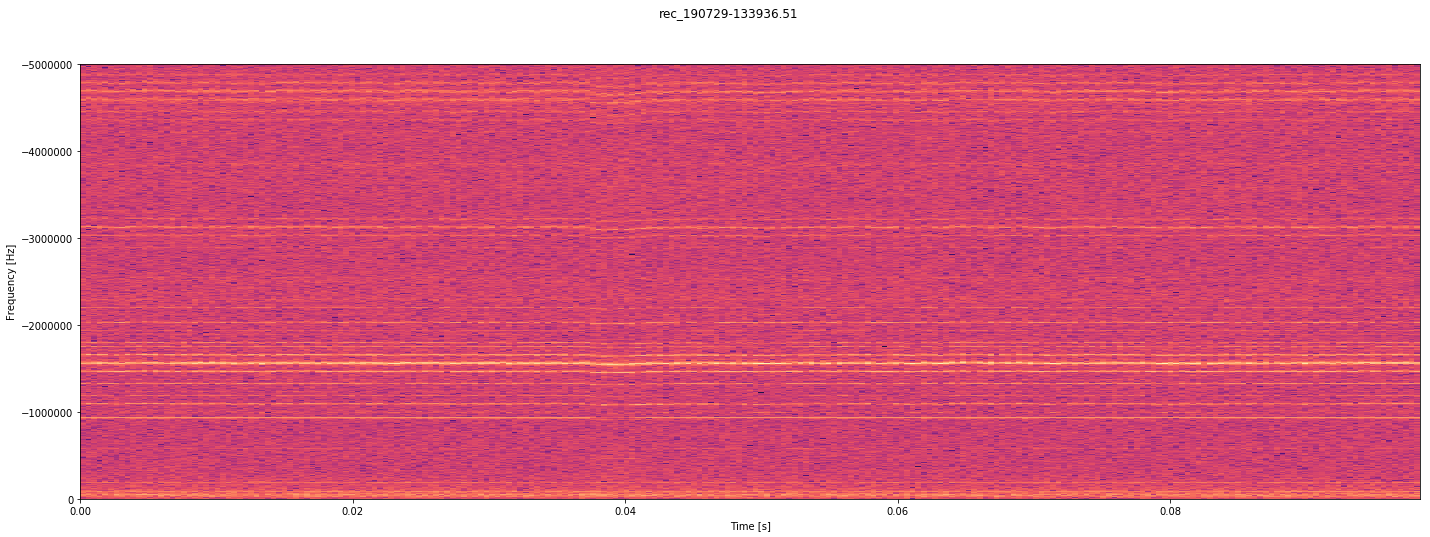

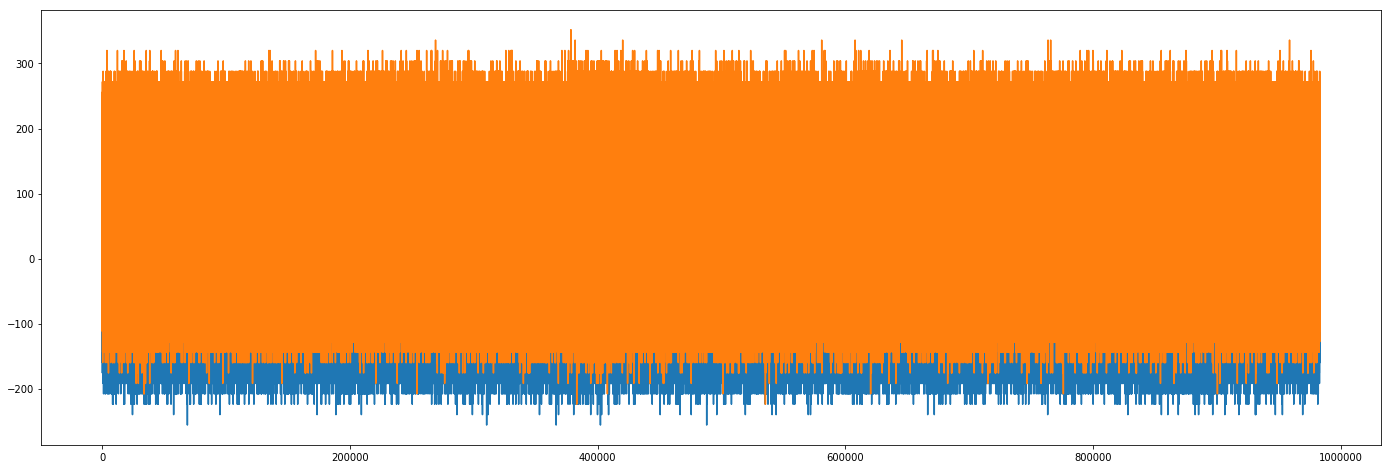

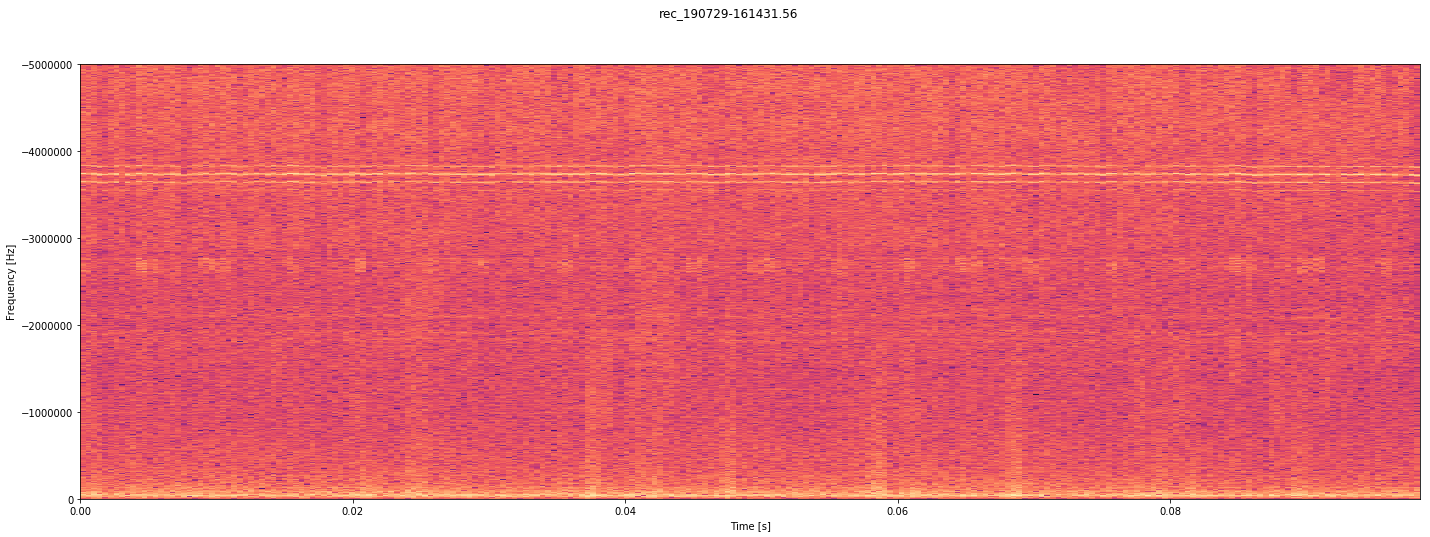

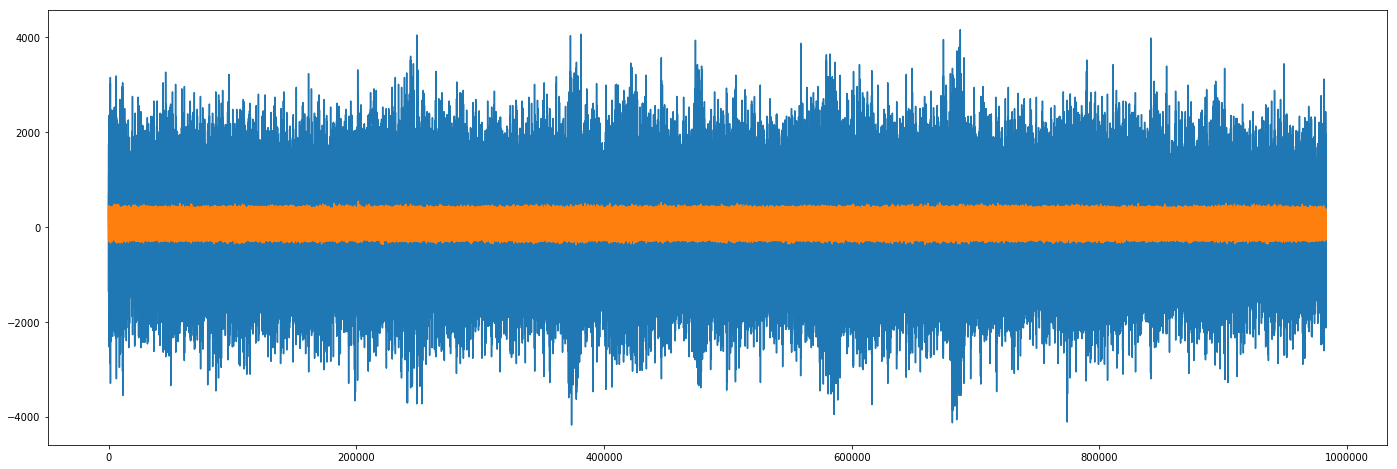

In [ ]:
import os
pre_trigger_blocks = 5
post_trigger_blocks = 10

for fn in os.listdir(path):
    with open(os.path.join(path, fn), 'rb') as f:
        try:
            h, samples, synclog = loadrec(f)
            a = (h['preTrigger']-pre_trigger_blocks)*h['descSpan']//16 #select block of samples before trigger
            b = (h['preTrigger']+post_trigger_blocks)*h['descSpan']//16  #select blocks after trigger 
            wf(samples[a:b,4], 10000000, bins=8192, title=fn)
            plt.ylim(bottom = 0) 
            plt.xlim(left = 0) 
            plt.subplots(figsize=(24, 8))
            plt.plot(samples[a:b,4:6])
            plt.show()
        except Exception as e:
            print(e)